### Проект: вариант 4
### Задание 1

Представьте, что вы аналитик в компании, которая разрабатывает приложение для обработки и оформления фотографий в формате Stories (например, для дальнейшего экспорта в Instagram Stories).
Был проведен A/B тест: тестовой группе предлагалась новая модель оплаты коллекций шаблонов, контрольной – старая механика
Ваша основная задача: проанализировать итоги эксперимента и решить, нужно ли выкатывать новую модель на остальных пользователей.

В ходе отчета обоснуйте выбор метрик, на которые вы обращаете внимание. Если различия есть, то объясните, с чем они могут быть связаны и являются ли значимыми.

Данные:

**active_users** – информация о пользователях, которые посещали приложение во время эксперимента.

**groups** – разбивка пользователей на контрольную (А) и тестовую (В) группы.

**purchases** – данные о транзакциях (оплатах) пользователей приложения во время эксперимента.

Задание 1:

я, если честно, не нашел айдишники, которые есть в purchases,
но нет в active_users: попробуй сджойнить эти два датасета с how=’outer’ 
и найти отсутствующие айдишники там, где revenue>0.
а вот насчет того, что далеко не все из groups были активными, ты, конечно, прав. 
И что их не надо включать в анализ — тоже прав.
Тут было бы интересно еще сравнить доли групп в groups и в активных и/или оплативших: на мой взгляд, если есть большие (значимые) перекосы, это могло бы означать проблемы со сплитованием.
на графиках в ячейках 29, 30, 31 ты сначала смотришь на группы по отдельности, а qq-plot строишь по объединенной выборке, и тест Шапиро тоже к ней применяешь.
Это странно.
вопрос на подумать: ты попытался прологарифмировать; 
ок, но если бы логарифмы были похожи на нормальное распределение, ты бы стал сравнивать средние t-тестом?
А из чего следует, что сравнение средних логарифмов это то же самое, что сравнение изначальных средних?
Да, логарифм это монотонно растущая функция (если x > y, то и ln(x) > ln(y) для любых положительных x и y), но означала бы статзначимость на логарифмах, что сами средние тоже значимо отличаются?
Признаю, это немножко хитрый вопрос, но подумать было бы полезно :)
    
вот такая формулировка «H0 - Изменений нет, разница средних случайна и обе группы принадлежат к одной генеральной совокупности» не корректна: 
    ты проверяешь только равенство средних, распределения (генеральные совокупности) могут при этом разные; посмотри внимательно на код функции get_bootsrap – там вычисляются только средние.
у нас есть данные также по странам, платформам и полу, в них может быть что-нибудь интересное: какие из этих переменных повлияли на рост выручки и как? Опять же, посмотреть, корректно ли сработала система сплитования? 
    М.б. еще что-то. К тому же, посмотри на условие задачи: «Если различия есть, то объясните, с чем они могут быть связаны...». Т.е. задача решена не полностью.
Задание 2:

Тут придираться не буду. Формулировка задачи очень общая, но будь готов защищать свой дашборд на созвоне: почему выбрал именно такие метрики, что с вовлеченностью и т.д.

Работа над ошибками:

полужирный шрифт выше.

In [2]:
# подгружаем необходимые библиотеки
import pandas as pd
import seaborn as sns
sns.set(
    font_scale=1.2,
    style="whitegrid",
    rc={'figure.figsize':(22,8)}
)
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, mannwhitneyu
from tqdm.auto import tqdm
import statsmodels.api as sm

## 1.Подготовка данных
Для начала загрузим все данные по пользователям, далее проверим тип данных, пропущенные значения (если есть) и посмотрим содержимое.

In [3]:
#подгружаем данные
active_users = pd.read_csv('Проект_4_active_users.csv')
groups = pd.read_csv('Проект_4_groups.csv')
purchases = pd.read_csv('Проект_4_purchases.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'Проект_4_active_users.csv'

In [7]:
active_users

,user_id,country,platform,sex
0,8029,Russia,ios,male
1,1735,Sweden,ios,male
2,7697,Russia,android,male
3,1421,Sweden,android,female
4,1704,Russia,ios,male
...,...,...,...,...
8336,2417,Sweden,ios,female
8337,3755,Russia,ios,male
8338,4594,Sweden,android,female
8339,7430,Sweden,ios,female


In [8]:
active_users.dtypes

user_id      int64
country     object
platform    object
sex         object
dtype: object

In [9]:
active_users.isna().sum()

user_id     0
country     0
platform    0
sex         0
dtype: int64

In [11]:
#проверим нет ли дублированных ID
if active_users.user_id.nunique() == active_users.user_id.count():
    print('OK')
else:
    print('Не OK'

OK


Колонки названы удобно, типы данных соответствуют самим данным,повторных id нет, пропущенных значений нет.
Проверим оставшиеся:

In [12]:
groups

,user_id,group
0,9149,B
1,9150,B
2,9151,A
3,9152,B
4,9153,B
...,...,...
74571,1010,B
74572,7785,A
74573,1783,B
74574,1164,A


In [13]:
groups.dtypes

user_id     int64
group      object
dtype: object

In [15]:
if groups.user_id.nunique() == groups.user_id.count():
    print('OK')
else:
    print('Не OK')

OK


In [16]:
groups.isna().sum()

user_id    0
group      0
dtype: int64

In [17]:
purchases

,user_id,revenue
0,4412,1000.0
1,9000,701.0
2,9001,700.0
3,9002,702.0
4,5790,1002.0
...,...,...
536,5648,1908.0
537,2277,1912.0
538,5032,1911.0
539,908,1910.0


In [18]:
#проверка на дублированные ID
if purchases.user_id.nunique() == purchases.user_id.count():
    print('OK')
else:
    print('Не OK')

OK


In [19]:
purchases.dtypes

user_id      int64
revenue    float64
dtype: object

In [20]:
purchases.isna().sum()

user_id    0
revenue    0
dtype: int64

In [21]:
purchases.revenue.min()

207.0

Тут все хорошо

Повторных id, пропущенных значений также нет.  
Данные хорошо подготовлены, с ними можно работать.

In [22]:
active_users_purchases= purchases.merge(active_users, how='inner', on='user_id')
active_users_purchases.user_id.value_counts().sum()

392

In [23]:
groups.user_id.count()

74576

Так, осталось всего 392 пользователя из 74576 в таблице *groups*.  
Это может означать, что есть пользователи которые совершали оплату без входа в приложение.  
Исключим этих пользователей, т.к. они не отвечают требованию о пользовании моделью оплаты в приложении.  
Также интересно что в таблице с разбивкой пользователей значительно больше, может быть разбивка происходила вообще по всем пользователям.

In [24]:
active_users_purchases_gr = active_users_purchases.merge(groups, how='left', on='user_id')
active_users_purchases_gr

,user_id,revenue,country,platform,sex,group
0,4412,1000.0,Russia,android,female,A
1,5790,1002.0,Sweden,android,male,B
2,2627,300.0,Russia,ios,female,B
3,7324,1910.0,Sweden,android,female,B
4,7666,701.0,Sweden,android,female,B
...,...,...,...,...,...,...
387,5648,1908.0,Sweden,android,female,B
388,2277,1912.0,Sweden,ios,female,B
389,5032,1911.0,Sweden,ios,male,B
390,908,1910.0,Sweden,android,male,B


Также нужно проверить есть ли пользователи, которые выполнили требование эксперимента (вошли в приложение, совершили покупку) но не были определены в тестовую/контрольную группу.

In [25]:
if active_users_purchases_gr.group.count().sum() == active_users_purchases.user_id.value_counts().sum():
    print('OK')
else:
    print('NOT OK')

OK


Все хорошо, идем дальше

## 3. Изучение данных и выбор критерия для проверки результата A/B-тестирования
У нас есть таблица со всеми интересующими нас данными, время взглянуть на разбивку по группам.

In [26]:
active_users_purchases_gr.groupby('group', as_index=False)\
    .agg({'user_id' : 'count'})

,group,user_id
0,A,78
1,B,314


Как мы убедились чуть ранее, все пользователи у нас уникальные. Но выборки оказались не одинакового размера - в тестовой 314 пользователей, в контрольной - 78.
Теперь посмотрим на выручку.

In [28]:
active_users_purchases_gr.groupby('group').agg({'revenue':'mean'})

,revenue
group,
A,943.564103
B,1267.875796


Среднее по тестовой группе выше, чем в контрольной. Посмотрим на выручку по группам на графике и все распределение.

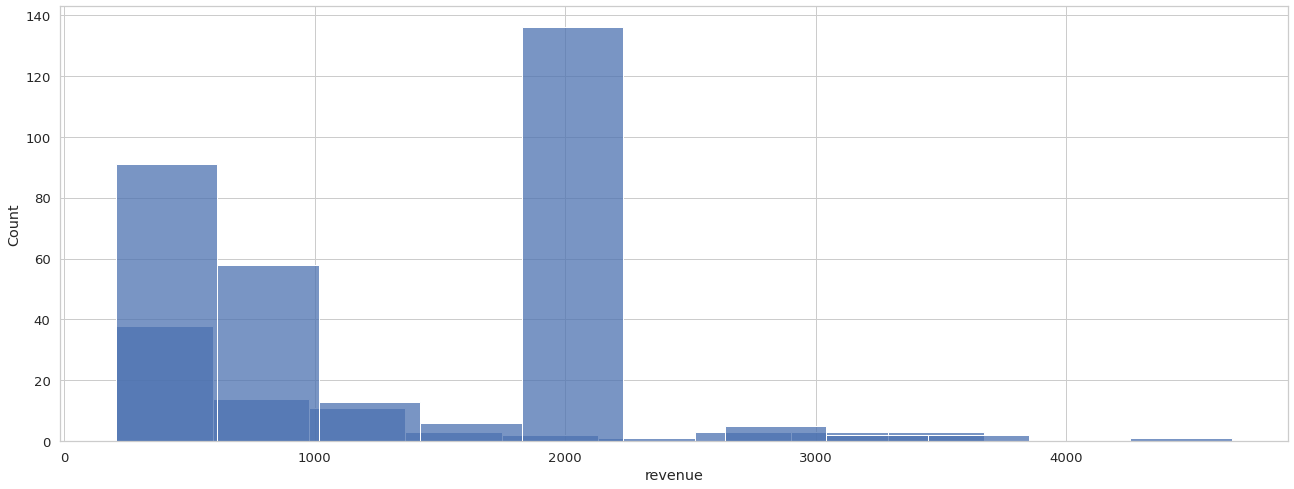

In [29]:
sns.histplot(active_users_purchases_gr.query('group == "A"').revenue)
sns.histplot(active_users_purchases_gr.query('group == "B"').revenue)

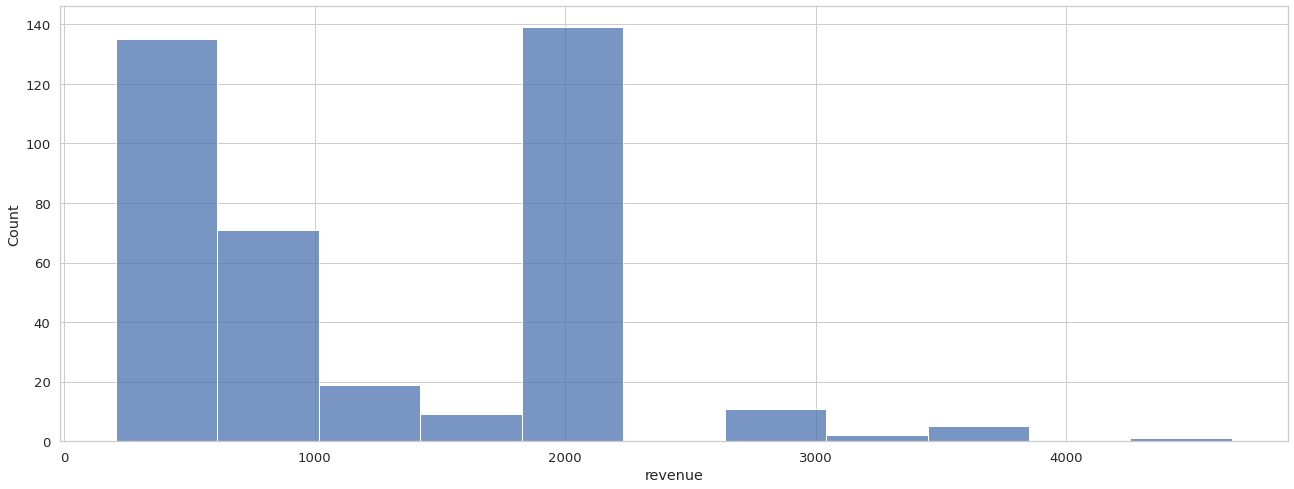

In [30]:
sns.histplot(active_users_purchases_gr.revenue)

Группы существенно различаются и тестовая группа заметно превосходит контрольную. 
Есть довольно большие выбросы.

Попробуем построить Q-Q Plot и посмотреть на данные.

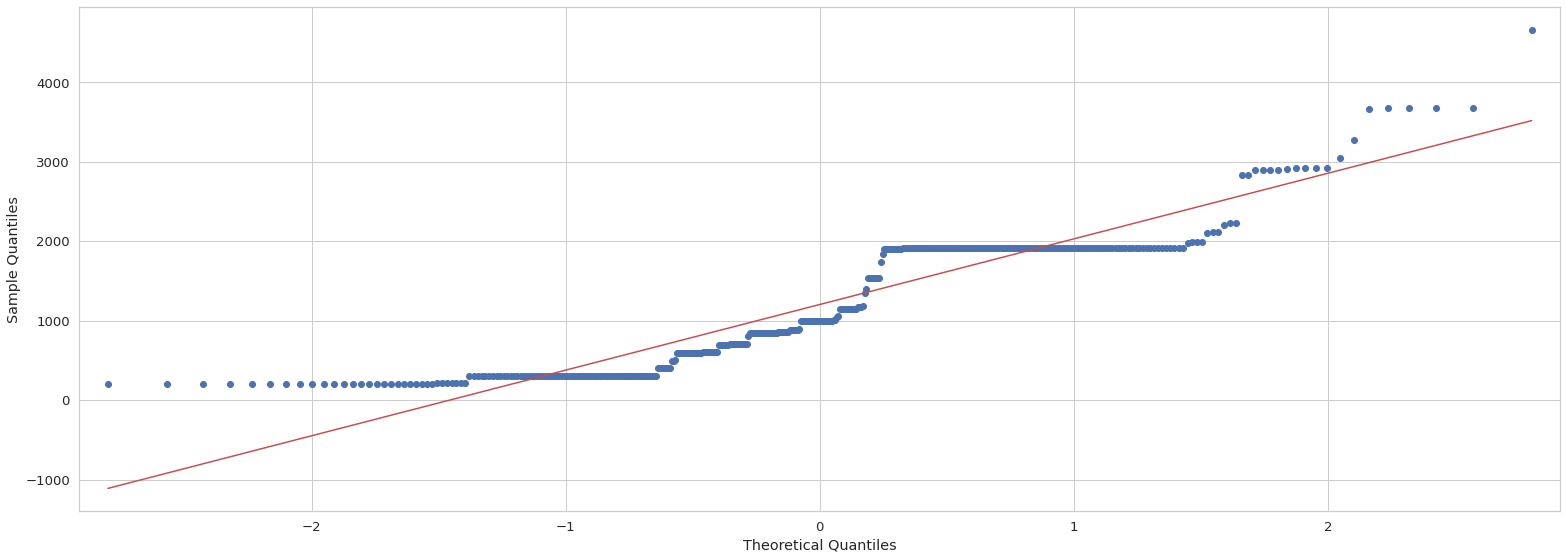

In [31]:
sm.qqplot(active_users_purchases_gr.revenue, line='s')
plt.tight_layout()
plt.show()

Распределение выглядит как ненормальное, кроме того есть большое количество одинаковых значений, есть значительные выбросы.    
Попробуем его нормализовать с помощью логарифмирования значений.

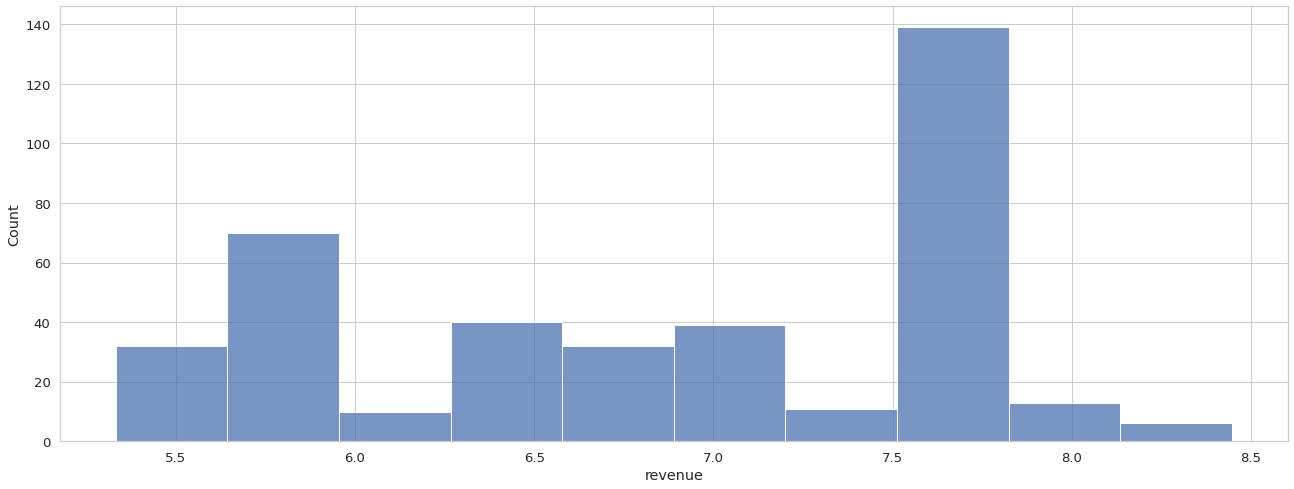

In [32]:
sns.histplot(np.log(active_users_purchases_gr.revenue))

Несмотря на логарифмирование и наблюдения на Q-Q Plot, однозначно сказать что распределние ненормальное, не получается. 
Остается проверить его тестом Шапиро-Уилка.  
Гипотезы:  
H0 - Выборка получена из нормального распределения   
H1 - Выборка получена из распределения, не являющимся нормальным  

In [33]:
stat, p = stats.shapiro(np.log(active_users_purchases_gr.revenue))
print(stat, p)
alpha = 0.05
if p > alpha:
    print('Распределение нормальное (Не отклоняем H0)')
else:
    print('Распределение ненормальное (Отклоняем H0)')

0.88338303565979 1.1665325838185404e-16
Распределение ненормальное (Отклоняем H0)


    p-value оказался меньше 0.05 и нулевая гипотеза была отклонена.
    Что мы имеем: 
1.  Количественный тип данных 
2.  Данные распределены ненормально 
3.  Группы независимы 
4.  Сравниваем две группы  

    Мог бы подойти U-критерий Манна-Уитни, но для его применения в выборках не должно быть одинаковых значений, а на Q-Q Plot они были явно заметны.    
    Проверим дополнительно:   




In [37]:
active_users_purchases_gr.groupby('revenue',as_index=False)\
    .agg({'group' : 'count'}).head(10)

,revenue,group
0,207.0,1
1,208.0,13
2,209.0,11
3,210.0,5
4,211.0,2
5,298.0,8
6,299.0,12
7,300.0,22
8,301.0,22
9,302.0,6


In [38]:
active_users_purchases_gr.query('revenue == 301.0')

,user_id,revenue,country,platform,sex,group
43,6308,301.0,Sweden,ios,male,A
59,3041,301.0,Sweden,ios,male,B
79,5840,301.0,Sweden,android,female,A
113,8263,301.0,Russia,ios,female,A
121,3062,301.0,Sweden,android,female,B
146,8044,301.0,Russia,android,female,B
174,1469,301.0,Russia,ios,female,A
179,3157,301.0,Russia,ios,male,B
193,6663,301.0,Sweden,android,female,A
199,7444,301.0,Sweden,android,female,B


Видно что, например, значение 301.0 повторяется как внутри каждой группы, так и между группами.   
Подведем итог: количественные данные распределены ненормальным образом, трансформирование переменной не помогло, условие для применения критерия Манна-Уитни не выполняется.    
Размеры групп значительно отличаются друг от друга.    
Лучшим решением в такой ситуации будет применить Bootstrap   

## 4.Применение Bootstrap

**Гипотезы**:   
H0 - Изменений нет, разница средних случайна и обе группы придналежат к одной генеральной совокупности.   
H1 - изменения есть и разница средних обсуловлена работой новой моделью оплаты, группы принадлежат разным генеральным совокупностям.   

In [39]:
def get_bootstrap(
        data_column_1, # контрольная группа
        data_column_2, # тестовая группа
        boot_it = 1000, # количество подвыборок
        statistic = np.mean, # проверяем гипотезу об увеличении среднего чека
        bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)]) # уравниваем размер выборок, взяв максимум
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки для контрольной и тестовой групп
        samples_1 = data_column_1.sample(
            boot_len,
            replace = True # значения обязательно должны вернуться в выборку
        ).values

        samples_2 = data_column_2.sample(
            boot_len,
            replace = True
        ).values

        boot_data.append(statistic(samples_1-samples_2)) # берём среднее от распределения разностей и добавляем в переменную

    pd_boot_data = pd.DataFrame(boot_data) # собираем датафрейм из средних

    # Считаем доверительный интервал для среднего. Если он попадёт в 0, то при уровне значимости
    # в 95% мы примем нулевую гипотезу
    # Используем перцентильный метод расчета доверительного интервала. Для этого берем 95% площади распределния,
    # вычислив 2.5 и 97.5 перцентили в бут-распределнии.

    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])

    # Вычисляем p-value по нормальному распределению

    p_1 = norm.cdf(
        x = 0,
        loc = np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0,
        loc = -np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)

    plt.vlines(ci,ymin=0,ymax=300,linestyle='--')
    plt.xlabel('boot_data', fontsize = 15)
    plt.ylabel('frequency', fontsize = 15)
    plt.title("Histogram of boot_data", fontsize = 18, pad = 50)
    plt.show()

    return {"boot_data": boot_data,
            "ci": ci,
            "p_value": p_value}

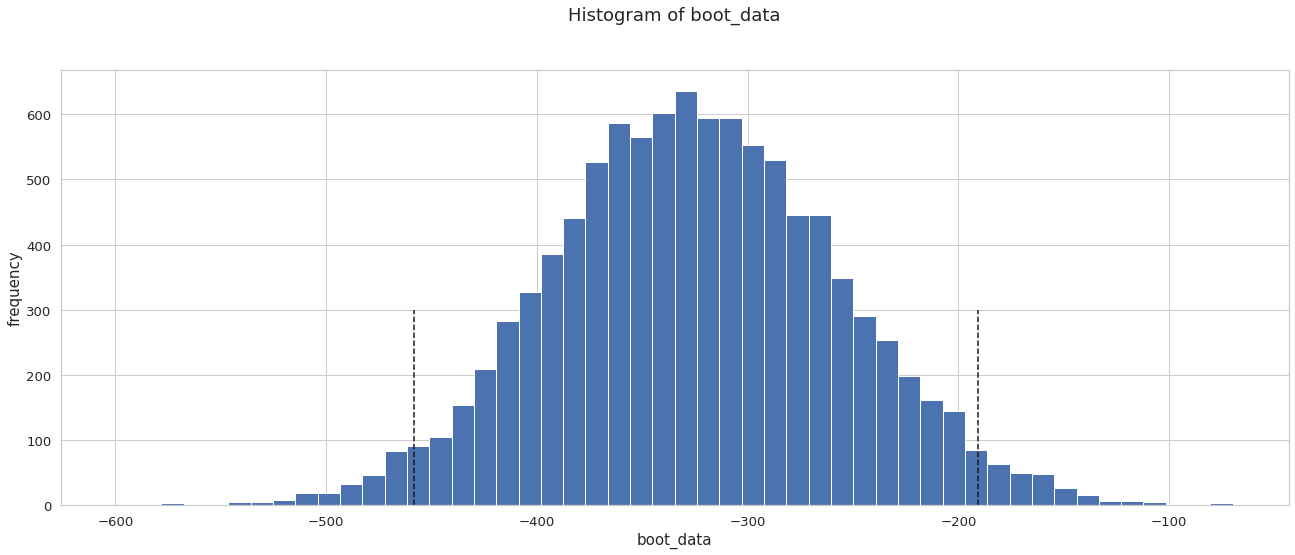

In [40]:
booted_data = get_bootstrap(
    active_users_purchases_gr.query('group == "A"').revenue, active_users_purchases_gr.query('group == "B"').revenue, boot_it = 10000)

In [41]:
booted_data['ci']

,0
0.025,-458.497213
0.975,-190.753822


In [42]:
booted_data['p_value']

1.7946252262310293e-06

## Итоги:
Доверительный интервал не попал в 0 - это означает, что отвергается нулевая  гипотеза.   
**Cтатистические значимые различия подтверждены** и новая модель оплаты действительно повлияла на увеличение среднего чека.   
Решение - выкатываем новую модель оплаты на всех пользователей.   